Predicting the age of abalone from physical measurements.  The age of
abalone is determined by cutting the shell through the cone, staining it,
and counting the number of rings through a microscope -- a boring and
time-consuming task.  Other measurements, which are easier to obtain, are
used to predict the age.  Further information, such as weather patterns
and location (hence food availability) may be required to solve the problem.

```
    Name		Data Type	Meas.	Description
	----		---------	-----	-----------
	Sex			   nominal		M, F, and I (infant)
	Length		continuous	mm	Longest shell measurement
	Diameter	        continuous	mm	perpendicular to length
	Height		continuous	mm	with meat in shell
	Whole weight	continuous	grams	whole abalone
	Shucked weight	continuous	grams	weight of meat
	Viscera weight	continuous	grams	gut weight (after bleeding)
	Shell weight	continuous	grams	after being dried
	Rings		integer			+1.5 gives the age in years
```


In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
import pyspark.sql.functions as sql_fun
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In Apache Spark, a SparkSession establishes a connection between your application code and the Spark cluster. It serves as an entry point to interact with various Spark functionalities and resources.

In [94]:
# Creating spark session
spark = SparkSession.builder.appName("Dataframe").getOrCreate()

In [95]:
# Reading csv file
df = spark.read.csv("./data/abalone.csv", header=True, inferSchema=True) # inferSchema try to cast column in valid type 
df.show()

+---+------+--------+------+------+-------+-------+-----+-----+
|Sex|Length|Diameter|Height| Whole|Shucked|Viscera|Shell|Rings|
+---+------+--------+------+------+-------+-------+-----+-----+
|  M| 0.455|   0.365| 0.095| 0.514| 0.2245|  0.101| 0.15|   15|
|  M|  0.35|   0.265|  0.09|0.2255| 0.0995| 0.0485| 0.07|    7|
|  F|  0.53|    0.42| 0.135| 0.677| 0.2565| 0.1415| 0.21|    9|
|  M|  0.44|   0.365| 0.125| 0.516| 0.2155|  0.114|0.155|   10|
|  I|  0.33|   0.255|  0.08| 0.205| 0.0895| 0.0395|0.055|    7|
|  I| 0.425|     0.3| 0.095|0.3515|  0.141| 0.0775| 0.12|    8|
|  F|  0.53|   0.415|  0.15|0.7775|  0.237| 0.1415| 0.33|   20|
|  F| 0.545|   0.425| 0.125| 0.768|  0.294| 0.1495| 0.26|   16|
|  M| 0.475|    0.37| 0.125|0.5095| 0.2165| 0.1125|0.165|    9|
|  F|  0.55|    0.44|  0.15|0.8945| 0.3145|  0.151| 0.32|   19|
|  F| 0.525|    0.38|  0.14|0.6065|  0.194| 0.1475| 0.21|   14|
|  M|  0.43|    0.35|  0.11| 0.406| 0.1675|  0.081|0.135|   10|
|  M|  0.49|    0.38| 0.135|0.5415| 0.21

In [96]:
# Types of columns
df.printSchema()

root
 |-- Sex: string (nullable = true)
 |-- Length: double (nullable = true)
 |-- Diameter: double (nullable = true)
 |-- Height: double (nullable = true)
 |-- Whole: double (nullable = true)
 |-- Shucked: double (nullable = true)
 |-- Viscera: double (nullable = true)
 |-- Shell: double (nullable = true)
 |-- Rings: integer (nullable = true)



In [97]:
# Statistical information
desc = df.describe()
desc.toPandas()

,summary,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
0,count,4177,4177,4177,4177,4177,4177,4177,4177,4177
1,mean,None,0.5239920995930099,0.407881254488869,0.1395163993296614,0.82874215944458,0.35936748862820106,0.18059360785252604,0.23883085946851795,9.933684462532918
2,stddev,None,0.12009291256479936,0.09923986613365941,0.04182705660725731,0.49038901823099795,0.22196294903322014,0.10961425025968445,0.13920266952238622,3.2241690320681315
3,min,F,0.075,0.055,0.0,0.002,0.001,5.0E-4,0.0015,1
4,max,M,0.815,0.65,1.13,2.8255,1.488,0.76,1.005,29


In [98]:
# Count of na values
df.select([sql_fun.sum(sql_fun.col(column).isNull().cast("integer")).alias(column) for column in df.columns]).show()

+---+------+--------+------+-----+-------+-------+-----+-----+
|Sex|Length|Diameter|Height|Whole|Shucked|Viscera|Shell|Rings|
+---+------+--------+------+-----+-------+-------+-----+-----+
|  0|     0|       0|     0|    0|      0|      0|    0|    0|
+---+------+--------+------+-----+-------+-------+-----+-----+



In [99]:
df.agg(*[sql_fun.sum(sql_fun.col(column).isNull().cast("int")).alias(column) for column in df.columns]).show()

+---+------+--------+------+-----+-------+-------+-----+-----+
|Sex|Length|Diameter|Height|Whole|Shucked|Viscera|Shell|Rings|
+---+------+--------+------+-----+-------+-------+-----+-----+
|  0|     0|       0|     0|    0|      0|      0|    0|    0|
+---+------+--------+------+-----+-------+-------+-----+-----+



PySpark DataFrame to a Pandas DataFrame may not be feasible for very large datasets that do not fit into memory. In such cases, you may need to consider alternative approaches, such as sampling the data or using distributed plotting libraries like Plotly or Bokeh.

In [100]:
# Ploting
sample_df = df.sample(withReplacement=False, fraction=0.25, seed=0)
sample_df = sample_df.toPandas()

In [101]:
sample_df.shape

(1049, 9)

Text(0.5, 1.0, 'Sex')

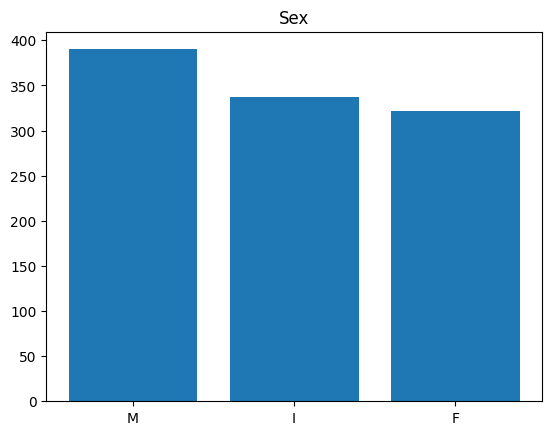

In [102]:
sex_count = sample_df["Sex"].value_counts()
plt.bar( sex_count.index, sex_count.values)
plt.title("Sex")

We have almost equal distribution for Sex

<Axes: >

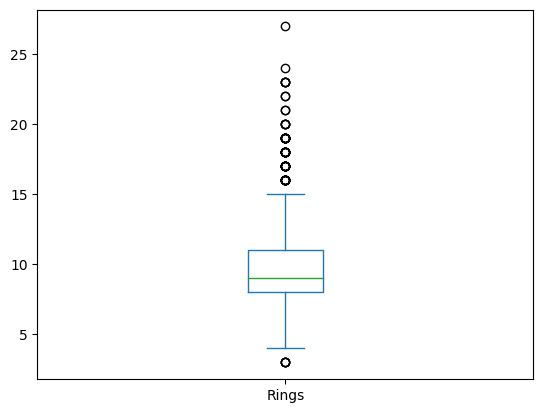

In [103]:
sample_df.Rings.plot.box()

Few Rings values are very high

<Axes: >

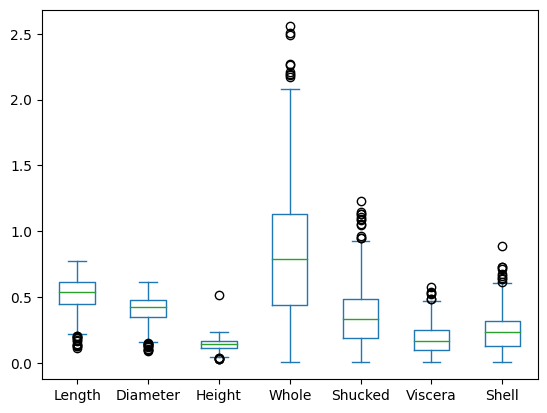

In [104]:
sample_df.iloc[:, :-1].plot.box()

There are few outliews according to box plot

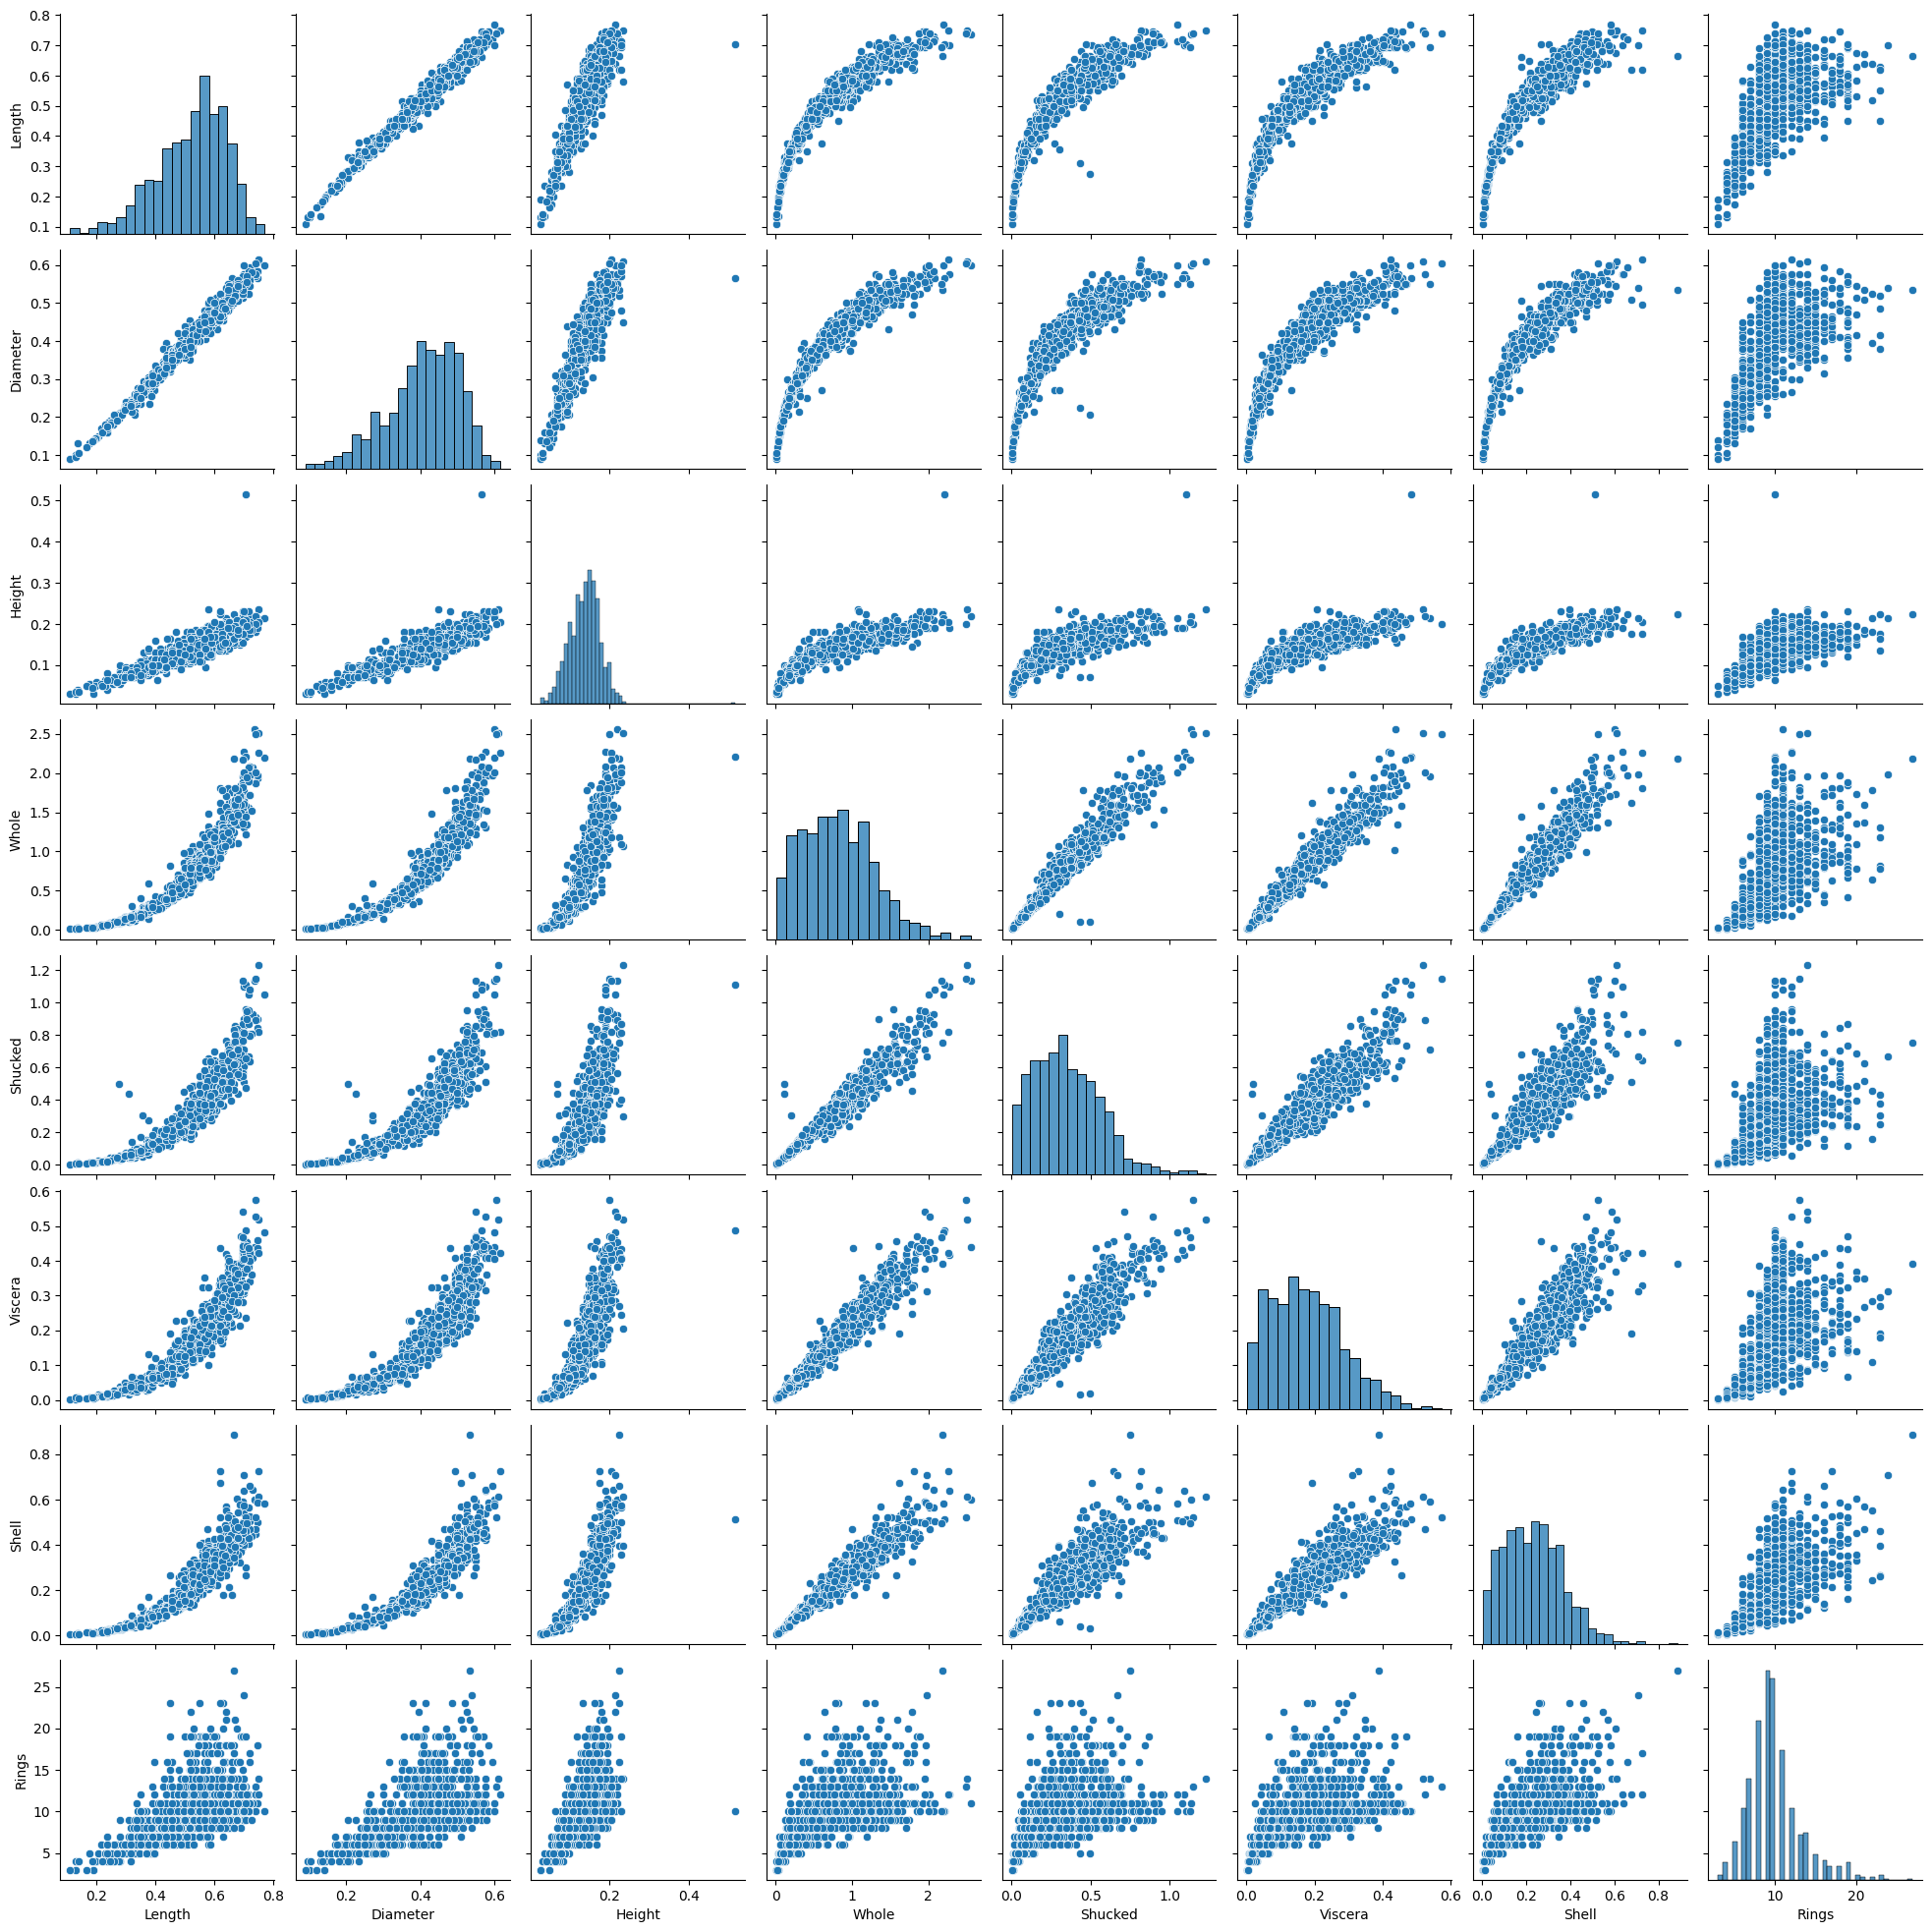

In [105]:
sns.pairplot(sample_df)

It seems few columns are linearly correlated with each other, mostly weight features

D:\Users\mduklan\AppData\Local\Temp\ipykernel_2960\781636349.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(sample_df.corr(), annot=True, fmt=".2", cmap="Greys",   vmax=1)


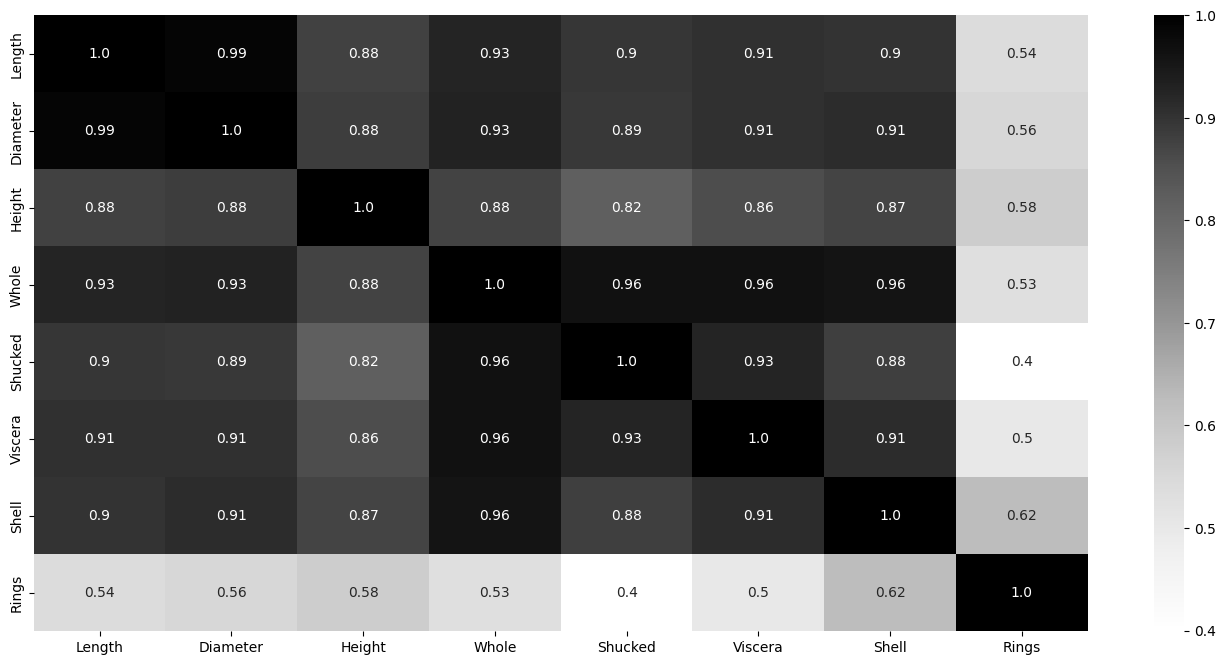

In [106]:
plt.figure(figsize=(17,8))
ax = sns.heatmap(sample_df.corr(), annot=True, fmt=".2", cmap="Greys",   vmax=1)
for t in ax.texts:
    if abs(float(t.get_text()))>=0.15:
        t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        t.set_text("")
plt.show()

As we can ses in correlation heatmap all values are highly correlated to each other which will cause multi colinearity problem

Removing highly correlated columns

Diameter and length are highly correlated since they are circular in shape, lets analyse them

<Axes: xlabel='Length', ylabel='Rings'>

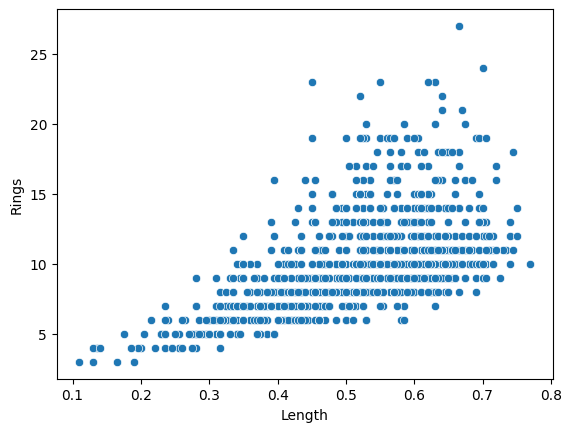

In [107]:
sns.scatterplot(x = sample_df.Length, y = sample_df.Rings)

<Axes: xlabel='Diameter', ylabel='Rings'>

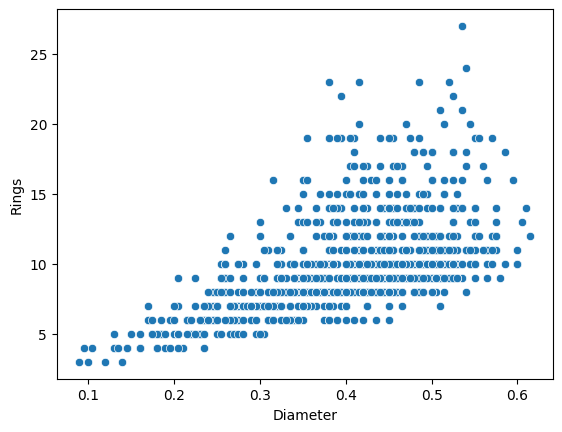

In [108]:
sns.scatterplot(x = sample_df.Diameter, y = sample_df.Rings)

Both of them look same in comparision to Rings, but Diameter have higher correlation with Rings we will keep Diameter

Whole is highly correlated to 3 features we will remove whole, since it is sum of 3 columns

In [109]:
df = df.drop("Length", "Whole")

In [110]:
df.show()

+---+--------+------+-------+-------+-----+-----+
|Sex|Diameter|Height|Shucked|Viscera|Shell|Rings|
+---+--------+------+-------+-------+-----+-----+
|  M|   0.365| 0.095| 0.2245|  0.101| 0.15|   15|
|  M|   0.265|  0.09| 0.0995| 0.0485| 0.07|    7|
|  F|    0.42| 0.135| 0.2565| 0.1415| 0.21|    9|
|  M|   0.365| 0.125| 0.2155|  0.114|0.155|   10|
|  I|   0.255|  0.08| 0.0895| 0.0395|0.055|    7|
|  I|     0.3| 0.095|  0.141| 0.0775| 0.12|    8|
|  F|   0.415|  0.15|  0.237| 0.1415| 0.33|   20|
|  F|   0.425| 0.125|  0.294| 0.1495| 0.26|   16|
|  M|    0.37| 0.125| 0.2165| 0.1125|0.165|    9|
|  F|    0.44|  0.15| 0.3145|  0.151| 0.32|   19|
|  F|    0.38|  0.14|  0.194| 0.1475| 0.21|   14|
|  M|    0.35|  0.11| 0.1675|  0.081|0.135|   10|
|  M|    0.38| 0.135| 0.2175|  0.095| 0.19|   11|
|  F|   0.405| 0.145| 0.2725|  0.171|0.205|   10|
|  F|   0.355|   0.1| 0.1675| 0.0805|0.185|   10|
|  M|     0.4|  0.13|  0.258|  0.133| 0.24|   12|
|  I|    0.28| 0.085|  0.095| 0.0395|0.115|    7|


In [111]:
sample_df = df.sample(withReplacement=False, fraction=0.25, seed=0)
sample_df = sample_df.toPandas()

D:\Users\mduklan\AppData\Local\Temp\ipykernel_2960\781636349.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(sample_df.corr(), annot=True, fmt=".2", cmap="Greys",   vmax=1)


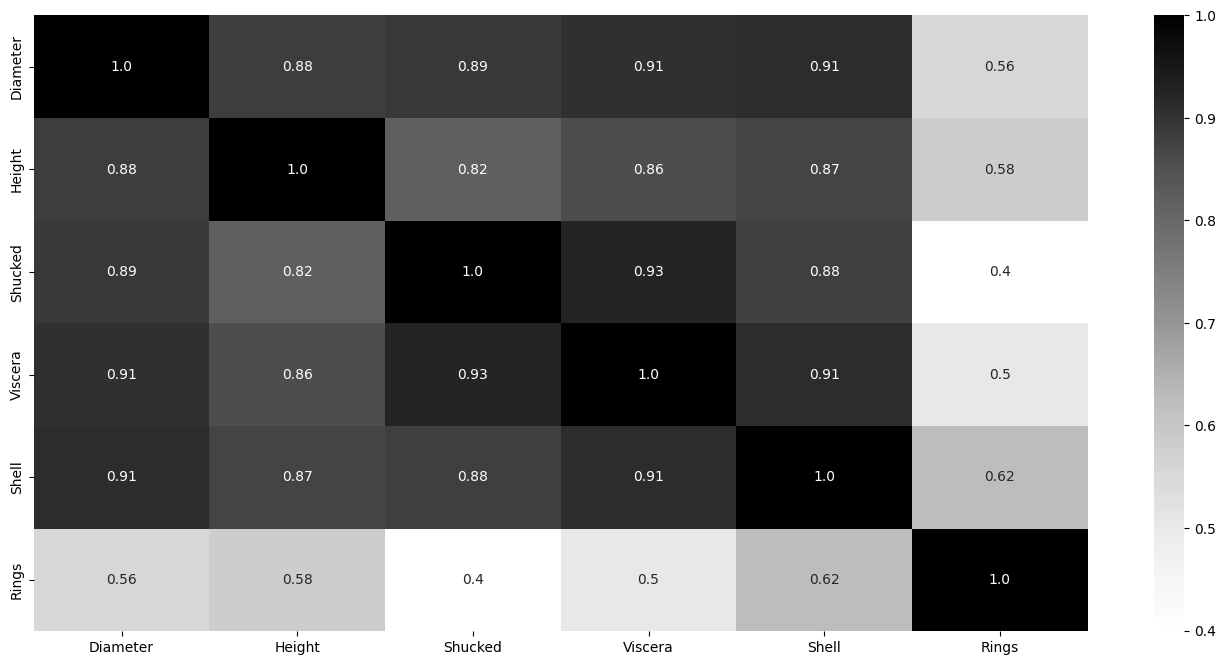

In [112]:
plt.figure(figsize=(17,8))
ax = sns.heatmap(sample_df.corr(), annot=True, fmt=".2", cmap="Greys",   vmax=1)
for t in ax.texts:
    if abs(float(t.get_text()))>=0.15:
        t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        t.set_text("")
plt.show()

Although correlation is still high but we will not drop them, since they are not derived

In [113]:
# Converting Sex to numeric
ordinal = StringIndexer(inputCol="Sex", outputCol="Sex_int")
ordinal_model = ordinal.fit(df)

In [114]:
df = ordinal_model.transform(df)

In [115]:
df.show()

+---+--------+------+-------+-------+-----+-----+-------+
|Sex|Diameter|Height|Shucked|Viscera|Shell|Rings|Sex_int|
+---+--------+------+-------+-------+-----+-----+-------+
|  M|   0.365| 0.095| 0.2245|  0.101| 0.15|   15|    0.0|
|  M|   0.265|  0.09| 0.0995| 0.0485| 0.07|    7|    0.0|
|  F|    0.42| 0.135| 0.2565| 0.1415| 0.21|    9|    2.0|
|  M|   0.365| 0.125| 0.2155|  0.114|0.155|   10|    0.0|
|  I|   0.255|  0.08| 0.0895| 0.0395|0.055|    7|    1.0|
|  I|     0.3| 0.095|  0.141| 0.0775| 0.12|    8|    1.0|
|  F|   0.415|  0.15|  0.237| 0.1415| 0.33|   20|    2.0|
|  F|   0.425| 0.125|  0.294| 0.1495| 0.26|   16|    2.0|
|  M|    0.37| 0.125| 0.2165| 0.1125|0.165|    9|    0.0|
|  F|    0.44|  0.15| 0.3145|  0.151| 0.32|   19|    2.0|
|  F|    0.38|  0.14|  0.194| 0.1475| 0.21|   14|    2.0|
|  M|    0.35|  0.11| 0.1675|  0.081|0.135|   10|    0.0|
|  M|    0.38| 0.135| 0.2175|  0.095| 0.19|   11|    0.0|
|  F|   0.405| 0.145| 0.2725|  0.171|0.205|   10|    2.0|
|  F|   0.355|

In [116]:
ohe = OneHotEncoder(inputCol="Sex_int", outputCol="Sex_encoded")
ohe_model = ohe.fit(df)

In [117]:
df = ohe_model.transform(df)

The format (2,[0],[1.0]) represents a sparse vector with a size of 2 (as specified by the first value). The [0] inside the square brackets indicates the position(s) where the non-zero value(s) are present, and the [1.0] represents the non-zero value(s) at the specified position(s).

```
+--------+--------------+----------------+
|category|category_index|category_encoded|
+--------+--------------+----------------+
|       A|           0.0|   (5,[0],[1.0])|
|       B|           1.0|   (5,[1],[1.0])|
|       C|           2.0|   (5,[2],[1.0])|
|       A|           0.0|   (5,[0],[1.0])|
|       D|           3.0|   (5,[3],[1.0])|
|       E|           4.0|   (5,[4],[1.0])|
|       F|           5.0|       (5,[],[])|
+--------+--------------+----------------+
```

In [118]:
df.show()

+---+--------+------+-------+-------+-----+-----+-------+-------------+
|Sex|Diameter|Height|Shucked|Viscera|Shell|Rings|Sex_int|  Sex_encoded|
+---+--------+------+-------+-------+-----+-----+-------+-------------+
|  M|   0.365| 0.095| 0.2245|  0.101| 0.15|   15|    0.0|(2,[0],[1.0])|
|  M|   0.265|  0.09| 0.0995| 0.0485| 0.07|    7|    0.0|(2,[0],[1.0])|
|  F|    0.42| 0.135| 0.2565| 0.1415| 0.21|    9|    2.0|    (2,[],[])|
|  M|   0.365| 0.125| 0.2155|  0.114|0.155|   10|    0.0|(2,[0],[1.0])|
|  I|   0.255|  0.08| 0.0895| 0.0395|0.055|    7|    1.0|(2,[1],[1.0])|
|  I|     0.3| 0.095|  0.141| 0.0775| 0.12|    8|    1.0|(2,[1],[1.0])|
|  F|   0.415|  0.15|  0.237| 0.1415| 0.33|   20|    2.0|    (2,[],[])|
|  F|   0.425| 0.125|  0.294| 0.1495| 0.26|   16|    2.0|    (2,[],[])|
|  M|    0.37| 0.125| 0.2165| 0.1125|0.165|    9|    0.0|(2,[0],[1.0])|
|  F|    0.44|  0.15| 0.3145|  0.151| 0.32|   19|    2.0|    (2,[],[])|
|  F|    0.38|  0.14|  0.194| 0.1475| 0.21|   14|    2.0|    (2,

- The VectorAssembler helps to combine these features into a single vector representation.
- By using VectorAssembler, we can convert individual columns into a vector column, which allows us to seamlessly integrate with these algorithms.
- single vector column makes it easier to apply transformations and feature scaling to the entire feature vector at once.

In [121]:
assembler = VectorAssembler(inputCols=["Sex_encoded","Diameter","Height","Shucked","Viscera","Shell"], outputCol="features")

In [123]:
df_assemble = assembler.transform(df)

In [124]:
df_assemble.show()

+---+--------+------+-------+-------+-----+-----+-------+-------------+--------------------+
|Sex|Diameter|Height|Shucked|Viscera|Shell|Rings|Sex_int|  Sex_encoded|            features|
+---+--------+------+-------+-------+-----+-----+-------+-------------+--------------------+
|  M|   0.365| 0.095| 0.2245|  0.101| 0.15|   15|    0.0|(2,[0],[1.0])|[1.0,0.0,0.365,0....|
|  M|   0.265|  0.09| 0.0995| 0.0485| 0.07|    7|    0.0|(2,[0],[1.0])|[1.0,0.0,0.265,0....|
|  F|    0.42| 0.135| 0.2565| 0.1415| 0.21|    9|    2.0|    (2,[],[])|[0.0,0.0,0.42,0.1...|
|  M|   0.365| 0.125| 0.2155|  0.114|0.155|   10|    0.0|(2,[0],[1.0])|[1.0,0.0,0.365,0....|
|  I|   0.255|  0.08| 0.0895| 0.0395|0.055|    7|    1.0|(2,[1],[1.0])|[0.0,1.0,0.255,0....|
|  I|     0.3| 0.095|  0.141| 0.0775| 0.12|    8|    1.0|(2,[1],[1.0])|[0.0,1.0,0.3,0.09...|
|  F|   0.415|  0.15|  0.237| 0.1415| 0.33|   20|    2.0|    (2,[],[])|[0.0,0.0,0.415,0....|
|  F|   0.425| 0.125|  0.294| 0.1495| 0.26|   16|    2.0|    (2,[],[])

In [129]:
# Scalling
minmax = MinMaxScaler(inputCol="features", outputCol="features_scalled")
minmax_model = minmax.fit(df_assemble)

In [131]:
df_scalled = minmax_model.transform(df_assemble)

In [132]:
df_scalled.show()

+---+--------+------+-------+-------+-----+-----+-------+-------------+--------------------+--------------------+
|Sex|Diameter|Height|Shucked|Viscera|Shell|Rings|Sex_int|  Sex_encoded|            features|    features_scalled|
+---+--------+------+-------+-------+-----+-----+-------+-------------+--------------------+--------------------+
|  M|   0.365| 0.095| 0.2245|  0.101| 0.15|   15|    0.0|(2,[0],[1.0])|[1.0,0.0,0.365,0....|[1.0,0.0,0.521008...|
|  M|   0.265|  0.09| 0.0995| 0.0485| 0.07|    7|    0.0|(2,[0],[1.0])|[1.0,0.0,0.265,0....|[1.0,0.0,0.352941...|
|  F|    0.42| 0.135| 0.2565| 0.1415| 0.21|    9|    2.0|    (2,[],[])|[0.0,0.0,0.42,0.1...|[0.0,0.0,0.613445...|
|  M|   0.365| 0.125| 0.2155|  0.114|0.155|   10|    0.0|(2,[0],[1.0])|[1.0,0.0,0.365,0....|[1.0,0.0,0.521008...|
|  I|   0.255|  0.08| 0.0895| 0.0395|0.055|    7|    1.0|(2,[1],[1.0])|[0.0,1.0,0.255,0....|[0.0,1.0,0.336134...|
|  I|     0.3| 0.095|  0.141| 0.0775| 0.12|    8|    1.0|(2,[1],[1.0])|[0.0,1.0,0.3,0.09

In [136]:
# Training regression
lr = LinearRegression(featuresCol="features_scalled", labelCol="Rings")

In [138]:
lr_model = lr.fit(df_scalled)

In [140]:
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.050998264608627455,-0.8749961692574346,6.453855286995639,12.511601398079897,-16.995870805554304,-0.6047839220578222,19.892589200541064]
Intercept: 4.358515550836136


In [145]:
df_scalled.show()

+---+--------+------+-------+-------+-----+-----+-------+-------------+--------------------+--------------------+
|Sex|Diameter|Height|Shucked|Viscera|Shell|Rings|Sex_int|  Sex_encoded|            features|    features_scalled|
+---+--------+------+-------+-------+-----+-----+-------+-------------+--------------------+--------------------+
|  M|   0.365| 0.095| 0.2245|  0.101| 0.15|   15|    0.0|(2,[0],[1.0])|[1.0,0.0,0.365,0....|[1.0,0.0,0.521008...|
|  M|   0.265|  0.09| 0.0995| 0.0485| 0.07|    7|    0.0|(2,[0],[1.0])|[1.0,0.0,0.265,0....|[1.0,0.0,0.352941...|
|  F|    0.42| 0.135| 0.2565| 0.1415| 0.21|    9|    2.0|    (2,[],[])|[0.0,0.0,0.42,0.1...|[0.0,0.0,0.613445...|
|  M|   0.365| 0.125| 0.2155|  0.114|0.155|   10|    0.0|(2,[0],[1.0])|[1.0,0.0,0.365,0....|[1.0,0.0,0.521008...|
|  I|   0.255|  0.08| 0.0895| 0.0395|0.055|    7|    1.0|(2,[1],[1.0])|[0.0,1.0,0.255,0....|[0.0,1.0,0.336134...|
|  I|     0.3| 0.095|  0.141| 0.0775| 0.12|    8|    1.0|(2,[1],[1.0])|[0.0,1.0,0.3,0.09

In [146]:
predictions = lr_model.transform(df_scalled)

In [148]:
predictions.show()

+---+--------+------+-------+-------+-----+-----+-------+-------------+--------------------+--------------------+------------------+
|Sex|Diameter|Height|Shucked|Viscera|Shell|Rings|Sex_int|  Sex_encoded|            features|    features_scalled|        prediction|
+---+--------+------+-------+-------+-----+-----+-------+-------------+--------------------+--------------------+------------------+
|  M|   0.365| 0.095| 0.2245|  0.101| 0.15|   15|    0.0|(2,[0],[1.0])|[1.0,0.0,0.365,0....|[1.0,0.0,0.521008...| 9.133082009260708|
|  M|   0.265|  0.09| 0.0995| 0.0485| 0.07|    7|    0.0|(2,[0],[1.0])|[1.0,0.0,0.265,0....|[1.0,0.0,0.352941...|7.8776927570183215|
|  F|    0.42| 0.135| 0.2565| 0.1415| 0.21|    9|    2.0|    (2,[],[])|[0.0,0.0,0.42,0.1...|[0.0,0.0,0.613445...|10.912941396019175|
|  M|   0.365| 0.125| 0.2155|  0.114|0.155|   10|    0.0|(2,[0],[1.0])|[1.0,0.0,0.365,0....|[1.0,0.0,0.521008...| 9.656879395938331|
|  I|   0.255|  0.08| 0.0895| 0.0395|0.055|    7|    1.0|(2,[1],[1.0]

In [149]:
# Ploting prediction
pandas_df = predictions.toPandas()

<Axes: ylabel='Rings'>

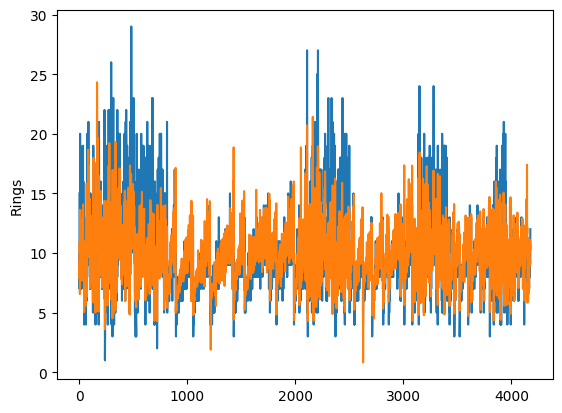

In [157]:
sns.lineplot(x = range(len(pandas_df)), y = pandas_df.Rings)
sns.lineplot(x = range(len(pandas_df)), y = pandas_df.prediction)

In [159]:
evaluator = RegressionEvaluator(labelCol="Rings", predictionCol="prediction", metricName="rmse")

In [161]:
evaluator.evaluate(predictions)

2.2314317208757135

In [168]:
print("R2", lr_model.summary.r2)
print("R2_adj", lr_model.summary.r2adj)
print("MSE", lr_model.summary.meanSquaredError)

R2 0.5208896137645097
R2_adj 0.5200851588104084
MSE 4.979287524930348


Trying with PCA

In [251]:
import numpy as np
from pyspark.ml.feature import PCA

In [252]:
# Reading csv file
df_pca = spark.read.csv("./data/abalone.csv", header=True, inferSchema=True) # inferSchema try to cast column in valid type 
df_pca.show()

+---+------+--------+------+------+-------+-------+-----+-----+
|Sex|Length|Diameter|Height| Whole|Shucked|Viscera|Shell|Rings|
+---+------+--------+------+------+-------+-------+-----+-----+
|  M| 0.455|   0.365| 0.095| 0.514| 0.2245|  0.101| 0.15|   15|
|  M|  0.35|   0.265|  0.09|0.2255| 0.0995| 0.0485| 0.07|    7|
|  F|  0.53|    0.42| 0.135| 0.677| 0.2565| 0.1415| 0.21|    9|
|  M|  0.44|   0.365| 0.125| 0.516| 0.2155|  0.114|0.155|   10|
|  I|  0.33|   0.255|  0.08| 0.205| 0.0895| 0.0395|0.055|    7|
|  I| 0.425|     0.3| 0.095|0.3515|  0.141| 0.0775| 0.12|    8|
|  F|  0.53|   0.415|  0.15|0.7775|  0.237| 0.1415| 0.33|   20|
|  F| 0.545|   0.425| 0.125| 0.768|  0.294| 0.1495| 0.26|   16|
|  M| 0.475|    0.37| 0.125|0.5095| 0.2165| 0.1125|0.165|    9|
|  F|  0.55|    0.44|  0.15|0.8945| 0.3145|  0.151| 0.32|   19|
|  F| 0.525|    0.38|  0.14|0.6065|  0.194| 0.1475| 0.21|   14|
|  M|  0.43|    0.35|  0.11| 0.406| 0.1675|  0.081|0.135|   10|
|  M|  0.49|    0.38| 0.135|0.5415| 0.21

In [253]:
df_pca = ordinal_model.transform(df_pca)

In [254]:
df_pca = ohe_model.transform(df_pca)

In [255]:
df_pca.show()

+---+------+--------+------+------+-------+-------+-----+-----+-------+-------------+
|Sex|Length|Diameter|Height| Whole|Shucked|Viscera|Shell|Rings|Sex_int|  Sex_encoded|
+---+------+--------+------+------+-------+-------+-----+-----+-------+-------------+
|  M| 0.455|   0.365| 0.095| 0.514| 0.2245|  0.101| 0.15|   15|    0.0|(2,[0],[1.0])|
|  M|  0.35|   0.265|  0.09|0.2255| 0.0995| 0.0485| 0.07|    7|    0.0|(2,[0],[1.0])|
|  F|  0.53|    0.42| 0.135| 0.677| 0.2565| 0.1415| 0.21|    9|    2.0|    (2,[],[])|
|  M|  0.44|   0.365| 0.125| 0.516| 0.2155|  0.114|0.155|   10|    0.0|(2,[0],[1.0])|
|  I|  0.33|   0.255|  0.08| 0.205| 0.0895| 0.0395|0.055|    7|    1.0|(2,[1],[1.0])|
|  I| 0.425|     0.3| 0.095|0.3515|  0.141| 0.0775| 0.12|    8|    1.0|(2,[1],[1.0])|
|  F|  0.53|   0.415|  0.15|0.7775|  0.237| 0.1415| 0.33|   20|    2.0|    (2,[],[])|
|  F| 0.545|   0.425| 0.125| 0.768|  0.294| 0.1495| 0.26|   16|    2.0|    (2,[],[])|
|  M| 0.475|    0.37| 0.125|0.5095| 0.2165| 0.1125|0.1

In [256]:
print(df_pca.columns)

['Sex', 'Length', 'Diameter', 'Height', 'Whole', 'Shucked', 'Viscera', 'Shell', 'Rings', 'Sex_int', 'Sex_encoded']


In [257]:
assembler_pca = VectorAssembler(inputCols=['Sex_encoded', 'Length', 'Diameter', 'Height', 'Whole', 'Shucked', 'Viscera', 'Shell'], outputCol="features")

In [191]:
df_pca_assemble = assembler_pca.transform(df_pca)

In [193]:
df_pca_assemble.show()

+---+------+--------+------+------+-------+-------+-----+-----+-------+-------------+--------------------+
|Sex|Length|Diameter|Height| Whole|Shucked|Viscera|Shell|Rings|Sex_int|  Sex_encoded|            features|
+---+------+--------+------+------+-------+-------+-----+-----+-------+-------------+--------------------+
|  M| 0.455|   0.365| 0.095| 0.514| 0.2245|  0.101| 0.15|   15|    0.0|(2,[0],[1.0])|[1.0,0.0,0.455,0....|
|  M|  0.35|   0.265|  0.09|0.2255| 0.0995| 0.0485| 0.07|    7|    0.0|(2,[0],[1.0])|[1.0,0.0,0.35,0.2...|
|  F|  0.53|    0.42| 0.135| 0.677| 0.2565| 0.1415| 0.21|    9|    2.0|    (2,[],[])|[0.0,0.0,0.53,0.4...|
|  M|  0.44|   0.365| 0.125| 0.516| 0.2155|  0.114|0.155|   10|    0.0|(2,[0],[1.0])|[1.0,0.0,0.44,0.3...|
|  I|  0.33|   0.255|  0.08| 0.205| 0.0895| 0.0395|0.055|    7|    1.0|(2,[1],[1.0])|[0.0,1.0,0.33,0.2...|
|  I| 0.425|     0.3| 0.095|0.3515|  0.141| 0.0775| 0.12|    8|    1.0|(2,[1],[1.0])|[0.0,1.0,0.425,0....|
|  F|  0.53|   0.415|  0.15|0.7775|  

In [259]:
minmax_pca = MinMaxScaler(inputCol="features", outputCol="features_scalled")

In [260]:
minmax_pca_model = minmax_pca.fit(df_pca_assemble)

In [261]:
df_pca_scalled = minmax_pca_model.transform(df_pca_assemble)

In [262]:
pca = PCA(k = 5, inputCol="features_scalled", outputCol="pca_features")

In [263]:
pca_model = pca.fit(df_pca_scalled)

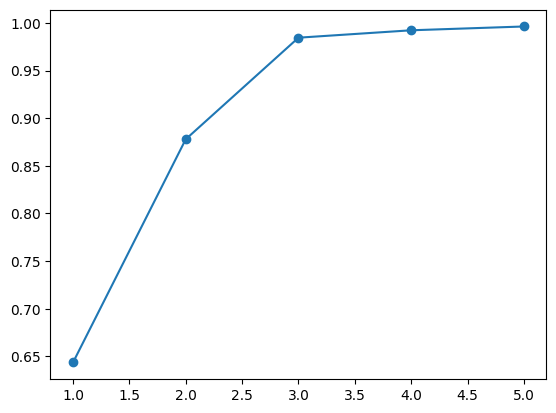

In [264]:
pca_variance = pca_model.explainedVariance.toArray()

cum_var = np.cumsum(pca_variance)

plt.plot(range(1, len(cum_var) + 1), cum_var, marker="o")


From the graph we can see that 3 components are able to capture all the variance

In [302]:
pca3 = PCA(k = 3, inputCol="features_scalled", outputCol="pca_features")

In [303]:
pca3_model = pca3.fit(df_pca_scalled)

In [304]:
df_pca3_applied = pca3_model.transform(df_pca_scalled)

In [305]:
df_pca3_applied.select("pca_features").first()

Row(pca_features=DenseVector([-0.8987, -0.3114, -0.7525]))

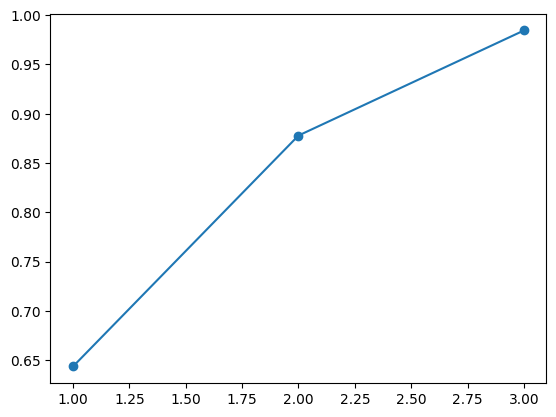

In [306]:
pca_variance = pca3_model.explainedVariance.toArray()

cum_var = np.cumsum(pca_variance)

plt.plot(range(1, len(cum_var) + 1), cum_var, marker="o")


In [307]:
df_pca3_applied.show()

+---+------+--------+------+------+-------+-------+-----+-----+-------+-------------+--------------------+--------------------+--------------------+
|Sex|Length|Diameter|Height| Whole|Shucked|Viscera|Shell|Rings|Sex_int|  Sex_encoded|            features|    features_scalled|        pca_features|
+---+------+--------+------+------+-------+-------+-----+-----+-------+-------------+--------------------+--------------------+--------------------+
|  M| 0.455|   0.365| 0.095| 0.514| 0.2245|  0.101| 0.15|   15|    0.0|(2,[0],[1.0])|[1.0,0.0,0.455,0....|[1.0,0.0,0.513513...|[-0.8987485543405...|
|  M|  0.35|   0.265|  0.09|0.2255| 0.0995| 0.0485| 0.07|    7|    0.0|(2,[0],[1.0])|[1.0,0.0,0.35,0.2...|[1.0,0.0,0.371621...|[-0.7957847698539...|
|  F|  0.53|    0.42| 0.135| 0.677| 0.2565| 0.1415| 0.21|    9|    2.0|    (2,[],[])|[0.0,0.0,0.53,0.4...|[0.0,0.0,0.614864...|[-0.3303438415874...|
|  M|  0.44|   0.365| 0.125| 0.516| 0.2155|  0.114|0.155|   10|    0.0|(2,[0],[1.0])|[1.0,0.0,0.44,0.3...|

In [308]:
lr_pca = LinearRegression(featuresCol="pca_features", labelCol="Rings")

In [309]:
lr_pca_model = lr_pca.fit(df_pca3_applied)

In [310]:
print("R2", lr_pca_model.summary.r2)
print("R2_adj", lr_pca_model.summary.r2adj)
print("MSE", lr_pca_model.summary.meanSquaredError)

R2 0.3309855622161658
R2_adj 0.33050460287915373
MSE 6.952918032584648
